In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import shap #shap图
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score #交叉验证
from sklearn.model_selection import GridSearchCV #网格搜索
from sklearn.metrics import classification_report 
import seaborn as sns #箱线图
import scipy #Pvalue显著性标注
from statannotations.Annotator import Annotator #Pvalue显著性标注

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
##调用分类器的相关包
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression as LR

In [3]:
##分类器名字
names = [
    "QDA",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "Lasso"
]

In [4]:
##分类器构建
classifiers = [
    QuadraticDiscriminantAnalysis(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    #SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #RandomForestClassifier(max_depth=5, n_estimators=12, max_features=1,random_state=311),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    linear_model.Lasso()]

# 读取文件并处理数据

In [5]:
fpath ="C:/Users/qjc/Documents/WeChat Files/wxid_1795xchr20ad21/FileStorage/File/2023-08/Data/PVT_816.csv"
df = pd.read_csv(fpath)
Center1 = (df["center"] == 1) #按照要求将数据按照中心0/中心1划分
Center0 = (df["center"] == 0)
print(Center1.sum(), Center0.sum())

468 348


In [17]:
Center0 = df.loc[df['center'] == 0]
#x_center0 = Center0.drop(columns = ['center', 'PVT', 'ID']) #中心0的数据形成特征矩阵，去掉中心、PVT、ID相关部分
x_center0 = Center0.drop(columns = ['center', 'PVT', 'ID', 'ST', 'TBIL', 'Spleen', 'ALB','Scr']) #14 features
x_center0_7features = Center0.loc[:, ['PV', 'PT', 'PTA', 'cps','PVD', 'APTT','Age']] #7 features
y_center0 = Center0['PVT']

Center1 = df.loc[df['center'] == 1]
#x_center1 = Center1.drop(columns = ['center', 'PVT', 'ID'])#中心1的数据形成特征矩阵，去掉中心、PVT、ID相关部分
x_center1 = Center1.drop(columns = ['center', 'PVT', 'ID', 'ST', 'TBIL', 'Spleen', 'ALB','Scr']) #14 features
x_center1_7features = Center1.loc[:, ['PV', 'PT', 'PTA', 'cps','PVD', 'APTT','Age']] #7 features
y_center1 = Center1['PVT']

nmp_y0 = y_center0.values
y0 = nmp_y0.reshape(-1,1)
nmp_y1 = y_center1.values
y1 = nmp_y1.reshape(-1,1)

x0 = x_center0.values
x1 = x_center1.values
x0_7 = x_center0_7features.values
x1_7 = x_center1_7features.values

print ("X_train:",len(x1), "X_test:",len(x0), "Y_train:",len(y1), "Y_test:", len(y0))

X_train: 468 X_test: 348 Y_train: 468 Y_test: 348


# 计算预测结果的各类参数

In [47]:
#计算灵敏度
def sensitivityCalc(Predictions, Labels):
    MCM = confusion_matrix(Labels, Predictions)
    # MCM此处是2分类的混淆矩阵

    # 切片操作，获取每一个类别各自的 tn, fp, tp, fn
    tn_sum = MCM[0, 0] # True Negative
    fp_sum = MCM[0, 1] # False Positive

    tp_sum = MCM[1, 1] # True Positive
    fn_sum = MCM[1, 0] # False Negative

    # 这里加1e-6，防止 0/0的情况计算得到nan，即tp_sum和fn_sum同时为0的情况
    Condition_negative = tp_sum + fn_sum + 1e-6

    sensitivity = tp_sum / Condition_negative
    macro_sensitivity = np.average(sensitivity, weights=None)

    micro_sensitivity = np.sum(tp_sum) / np.sum(tp_sum+fn_sum)

    return macro_sensitivity

In [38]:
#计算特异性
def specificityCalc(Predictions, Labels):
    MCM = confusion_matrix(Labels, Predictions)
    tn_sum = MCM[0, 0]
    fp_sum = MCM[0, 1]

    tp_sum = MCM[1, 1]
    fn_sum = MCM[1, 0]

    Condition_negative = tn_sum + fp_sum + 1e-6

    Specificity = tn_sum / Condition_negative
    macro_specificity = np.average(Specificity, weights=None)

    #micro_specificity = np.sum(tn_sum) / np.sum(tn_sum+fp_sum)

    return macro_specificity

In [44]:
#计算召回率
def recallCalc(Predictions, Labels):
    
    macro_recall = recall_score(Labels, Predictions)

    return macro_recall

In [9]:
#计算精确率
def precisionCalc(Predictions, Labels):

    macro_precision = precision_score(Labels, Predictions)

    return macro_precision

# 迭代不同的分类器计算结果并写入表格

In [32]:
#center1上训练，在center1上predict
results = pd.DataFrame(columns = ['classifier','AUC','ACC','PRE','SEN'])
for name, clf in zip(names, classifiers):
    clf.fit(x1, y1)
    if name == "RBF SVM": #当分类器为RBF SVM计算y_pred和y_prob
        y_pred = clf.predict(x1)
        y_prob = y_pred
    if name == "Lasso":#当分类器为Lasso计算y_pred和y_prob
        y_prob = clf.predict(x1)
        y_pred = np.around(y_prob,0).astype(int)
    else:
        y_pred = clf.predict(x1)
        y_prob = clf.predict_proba(x1)[:,1] 
    score = metrics.accuracy_score(y1, y_pred)
    fpr, tpr, threshod = metrics.roc_curve(y1,y_prob)
    roc_auc = auc(fpr,tpr)
    precision = precisionCalc(y_pred,y1)
    recall = recallCalc(y_pred,y1)
    results = results.append({'classifier':name,'AUC':roc_auc,'ACC':score,'PRE':precision,'SEN':recall},ignore_index=True)
results

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

,classifier,AUC,ACC,PRE,SEN
0,QDA,0.833605,0.634615,0.878788,0.262443
1,Nearest Neighbors,0.873541,0.799145,0.792627,0.778281
2,Linear SVM,0.750508,0.690171,0.668142,0.683258
3,RBF SVM,0.000000,1.000000,1.000000,1.000000
4,Gaussian Process,1.000000,1.000000,1.000000,1.000000
5,Decision Tree,0.878268,0.790598,0.828877,0.701357
6,Random Forest,0.877214,0.767094,0.759259,0.742081
7,Neural Net,0.823969,0.732906,0.684615,0.805430
8,AdaBoost,0.903237,0.803419,0.789238,0.796380
9,Naive Bayes,0.745159,0.613248,0.743902,0.276018


In [54]:
#结果输出为csv格式
results.to_csv('C:/Users/qjc/Documents/WeChat Files/wxid_1795xchr20ad21/FileStorage/File/2023-08/Data/Results_7features1.csv',sep=',')

In [48]:
#center1上训练，在center0上predict
results = pd.DataFrame(columns = ['classifier','AUC','ACC','PRE','SEN'])
for name, clf in zip(names, classifiers):
    clf.fit(x1, y1)
    if name == "RBF SVM": #当分类器为RBF SVM计算y_pred和y_prob       
        y_pred = clf.predict(x0)
        y_prob = y_pred
    if name == "Lasso":#当分类器为Lasso计算y_pred和y_prob
        y_prob = clf.predict(x0)
        y_pred = np.around(y_prob,0).astype(int)
    else:
        y_pred = clf.predict(x0)
        y_prob = clf.predict_proba(x0)[:,1] 
    score = metrics.accuracy_score(y0, y_pred)
    fpr, tpr, threshod = metrics.roc_curve(y0,y_prob)
    roc_auc = auc(fpr,tpr)
    precision = precisionCalc(y_pred,y0)
    recall = recallCalc(y_pred,y0)
    sens = sensitivityCalc(y_pred,y0)
    results = results.append({'classifier':name,'AUC':roc_auc,'ACC':score,'PRE':precision,'SEN':recall},ignore_index=True)
results

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control

,classifier,AUC,ACC,PRE,SEN
0,QDA,0.758658,0.821839,0.414286,0.58
1,Nearest Neighbors,0.548188,0.635057,0.186992,0.46
2,Linear SVM,0.760134,0.698276,0.268908,0.64
3,RBF SVM,0.500000,0.856322,0.000000,0.00
4,Gaussian Process,0.500000,0.652299,0.168224,0.36
5,Decision Tree,0.649161,0.738506,0.226667,0.34
6,Random Forest,0.715738,0.729885,0.270833,0.52
7,Neural Net,0.689530,0.706897,0.234694,0.46
8,AdaBoost,0.725839,0.770115,0.285714,0.40
9,Naive Bayes,0.763423,0.856322,0.500000,0.40


In [26]:
results.round(3).to_csv('C:/Users/qjc/Documents/WeChat Files/wxid_1795xchr20ad21/FileStorage/File/2023-08/Data/Results_7features1withoutage.csv',sep=',')

In [104]:
#补充：计算逻辑回归分类的各项指标和参数
clf = LR()
clf.fit(x1_7, y1)
y_pred = clf.predict(x0_7)
y_prob = clf.predict_proba(x0_7)[:,1] 
score = metrics.accuracy_score(y0, y_pred)
fpr, tpr, threshod = metrics.roc_curve(y0,y_prob)
roc_auc = auc(fpr,tpr)
precision = precisionCalc(y_pred,y0)
recall = recallCalc(y_pred,y0)
print(roc_auc, score, precision, recall)

0.7863758389261745 0.7672413793103449 0.3258426966292135 0.58


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [31]:
#计算QDA在7个features时和其他分类器用14个features的各项指标，auroc柱状图需要
#center1上训练，在center0上predict
results = pd.DataFrame(columns = ['classifier','AUC','ACC','PRE','SEN'])
for name, clf in zip(names, classifiers):
    if name == "QDA": #当分类器为QDA时，用7个features分类
        clf.fit(x1_7, y1)
        y_pred = clf.predict(x0_7)
        y_prob = clf.predict_proba(x0_7)[:,1]
        score = metrics.accuracy_score(y0, y_pred)
        fpr, tpr, threshod_ = metrics.roc_curve(y0,y_prob)
        roc_auc = auc(fpr,tpr)
        precision = precisionCalc(y_pred,y0)
        recall = recallCalc(y_pred,y0)
        results = results.append({'classifier':name,'AUC':roc_auc,'ACC':score,'PRE':precision,'SEN':recall},ignore_index=True)
    #其他分类器用全部14个features做分类
    if name == "RBF SVM":
        clf.fit(x1, y1)
        y_pred = clf.predict(x0)
        y_prob = y_pred
        score = metrics.accuracy_score(y0, y_pred)
        fpr, tpr, threshod = metrics.roc_curve(y0,y_prob)
        roc_auc = auc(fpr,tpr)
        precision = precisionCalc(y_pred,y0)
        recall = recallCalc(y_pred,y0)
    if name == "Lasso":
        clf.fit(x1, y1)
        y_prob = clf.predict(x0)
        y_pred = np.around(y_prob,0).astype(int)
        score = metrics.accuracy_score(y0, y_pred)
        fpr, tpr, threshod = metrics.roc_curve(y0,y_prob)
        roc_auc = auc(fpr,tpr)
        precision = precisionCalc(y_pred,y0)
        recall = recallCalc(y_pred,y0)
    else:
        clf.fit(x1, y1)
        y_pred = clf.predict(x0)
        y_prob = clf.predict_proba(x0)[:,1]
        score = metrics.accuracy_score(y0, y_pred)
        fpr, tpr, threshod = metrics.roc_curve(y0,y_prob)
        roc_auc = auc(fpr,tpr)
        precision = precisionCalc(y_pred,y0)
        recall = recallCalc(y_pred,y0)
    results = results.append({'classifier':name,'AUC':roc_auc,'ACC':score,'PRE':precision,'SEN':recall},ignore_index=True)
results.drop(results.index[1], inplace = True)
results

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

,classifier,AUC,ACC,PRE,SEN
0,QDA,0.864698,0.732759,0.328000,0.82
2,Nearest Neighbors,0.548188,0.635057,0.186992,0.46
3,Linear SVM,0.760134,0.698276,0.268908,0.64
4,RBF SVM,0.500000,0.856322,0.000000,0.00
5,Gaussian Process,0.500000,0.652299,0.168224,0.36
6,Decision Tree,0.649161,0.738506,0.226667,0.34
7,Random Forest,0.687517,0.712644,0.239583,0.46
8,Neural Net,0.697248,0.629310,0.223776,0.64
9,AdaBoost,0.725839,0.770115,0.285714,0.40
10,Naive Bayes,0.763423,0.856322,0.500000,0.40


In [50]:
#输出结果到csv格式
results.to_csv('C:/Users/qjc/Documents/WeChat Files/wxid_1795xchr20ad21/FileStorage/File/2023-08/Data/Results_7features.csv',sep=',')

In [33]:
#center0上训练，在center0上predict
results = pd.DataFrame(columns = ['classifier','AUC','ACC','PRE','SEN'])
for name, clf in zip(names, classifiers):
    clf.fit(x0, y0)
    if name == "RBF SVM":#当分类器为RBF SVM计算y_pred和y_prob
        y_pred = clf.predict(x0)
        y_prob = y_pred
    if name == "Lasso":#当分类器为Lasso计算y_pred和y_prob
        y_prob = clf.predict(x0)
        y_pred = np.around(y_prob,0).astype(int)
    else:
        y_pred = clf.predict(x0)
        y_prob = clf.predict_proba(x0)[:,1] 
    score = metrics.accuracy_score(y0, y_pred)
    fpr, tpr, threshod = metrics.roc_curve(y0,y_prob)
    roc_auc = auc(fpr,tpr)
    precision = precisionCalc(y_pred,y0)
    recall = recallCalc(y_pred,y0)
    results = results.append({'classifier':name,'AUC':roc_auc,'ACC':score,'PRE':precision,'SEN':recall},ignore_index=True)
results

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

,classifier,AUC,ACC,PRE,SEN
0,QDA,0.992416,0.959770,0.781250,1.00
1,Nearest Neighbors,0.999866,0.994253,0.961538,1.00
2,Linear SVM,0.881946,0.887931,0.823529,0.28
3,RBF SVM,1.000000,1.000000,1.000000,1.00
4,Gaussian Process,1.000000,1.000000,1.000000,1.00
5,Decision Tree,0.963758,0.913793,1.000000,0.40
6,Random Forest,0.999396,0.939655,1.000000,0.58
7,Neural Net,0.999195,0.988506,1.000000,0.92
8,AdaBoost,1.000000,1.000000,1.000000,1.00
9,Naive Bayes,0.878121,0.864943,0.522388,0.70


In [34]:
#center0上训练，在center1上predict
results = pd.DataFrame(columns = ['classifier','AUC','ACC','PRE','SEN'])
for name, clf in zip(names, classifiers):
    clf.fit(x0, y0)
    if name == "RBF SVM":#当分类器为RBF SVM计算y_pred和y_prob
        y_pred = clf.predict(x1)
        y_prob = y_pred
    if name == "Lasso":#当分类器为Lasso计算y_pred和y_prob
        y_prob = clf.predict(x1)
        y_pred = np.around(y_prob,0).astype(int)
    else:
        y_pred = clf.predict(x1)
        y_prob = clf.predict_proba(x1)[:,1] 
    score = metrics.accuracy_score(y1, y_pred)
    fpr, tpr, threshod = metrics.roc_curve(y1,y_prob)
    roc_auc = auc(fpr,tpr)
    precision = precisionCalc(y_pred,y1)
    recall = recallCalc(y_pred,y1)
    results = results.append({'classifier':name,'AUC':roc_auc,'ACC':score,'PRE':precision,'SEN':recall},ignore_index=True)
results

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control

,classifier,AUC,ACC,PRE,SEN
0,QDA,0.572939,0.536325,0.750000,0.027149
1,Nearest Neighbors,0.490904,0.504274,0.452174,0.235294
2,Linear SVM,0.519034,0.487179,0.473829,0.778281
3,RBF SVM,0.500000,0.527778,0.000000,0.000000
4,Gaussian Process,0.474344,0.551282,0.571429,0.199095
5,Decision Tree,0.555132,0.534188,0.516129,0.217195
6,Random Forest,0.579011,0.519231,0.388889,0.031674
7,Neural Net,0.608167,0.589744,0.577540,0.488688
8,AdaBoost,0.502198,0.512821,0.482234,0.429864
9,Naive Bayes,0.477788,0.497863,0.482500,0.873303


# SHAP

In [ ]:
#迭代不同的分类器并绘制shap图
for name, clf in zip(names, classifiers):
    clf.fit(x1, y1)  ##根据需要或要求使用center0/center1的数据进行训练
    explainer = shap.KernelExplainer(clf.predict, x0)
    shap_values = explainer(x0)
    shap.plots.bar(shap_values, max_display=20,show=False)#show=false利用plt绘图
    plt.title(name)
    plt.savefig(".../shap output/name.png",dpi=100,bbox_inches='tight')
    plt.show()

In [ ]:
#迭代分类器绘制beeswarm图
for name, clf in zip(names, classifiers):
    clf.fit(x1, y1)
    explainer = shap.KernelExplainer(clf.predict, x0)
    shap_values = explainer(x0)
    shap.plots.beeswarm(shap_values, max_display=20,show=False)#show=false利用plt绘图
    plt.title(name)
    plt.savefig(".../shap output/name.png",dpi=100,bbox_inches='tight')
    plt.show()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Using 348 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/348 [00:00<?, ?it/s]

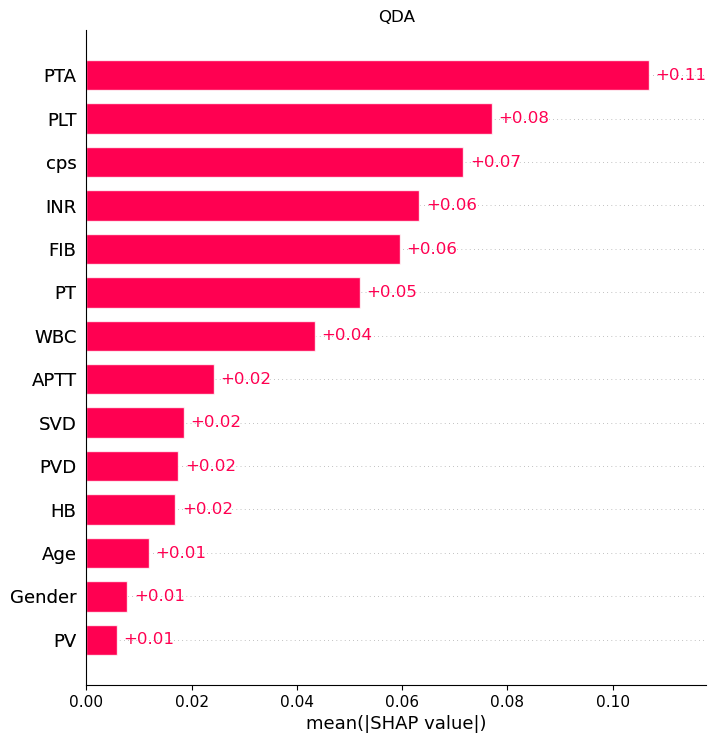

In [60]:
#根据要求单独绘制QDA的shap总体柱状图
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(x1, y1)
explainer = shap.KernelExplainer(QDA.predict, x0)
shap_values = explainer(x0)
shap.plots.bar(shap_values, max_display=20,show=False)#show=false利用plt绘图
plt.title("QDA")
plt.savefig("E:/算法和数据结构/python/shap output/PVT-816/QDA.png",dpi=200,bbox_inches='tight')
plt.show()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Using 348 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/348 [00:00<?, ?it/s]

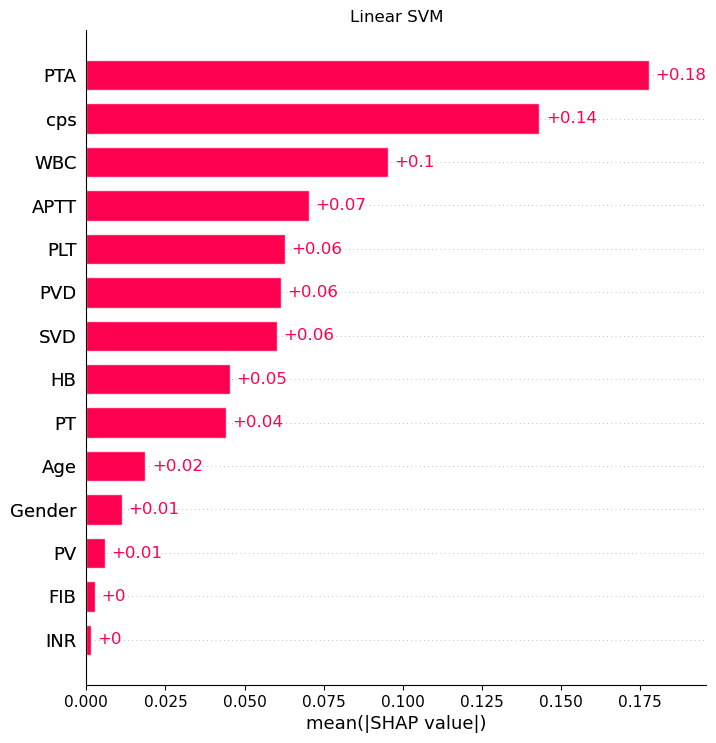

In [61]:
#根据要求单独绘制Linear SVM的shap总体柱状图
svm = SVC(kernel="linear", C=0.01, probability=True)
svm.fit(x1, y1)
explainer = shap.KernelExplainer(svm.predict, x0)
shap_values = explainer(x0)
shap.plots.bar(shap_values, max_display=20,show=False)#show=false利用plt绘图
plt.title("Linear SVM")
plt.savefig("E:/算法和数据结构/python/shap output/PVT-816/Linear SVM.png",dpi=200,bbox_inches='tight')
plt.show()

# AUROC柱状图、曲线图、QDA的auc值对比

In [132]:
#为数据添加多一级datasets便于作图
results.loc[:, 'datasets'] = 'Test'
results

,classifier,AUC,ACC,PRE,SEN,datasets
0,Nearest Neighbors,0.648792,0.695402,0.240741,0.52,Test
1,Linear SVM,0.762013,0.695402,0.254386,0.58,Test
2,RBF SVM,0.447148,0.856322,0.000000,0.00,Test
3,Gaussian Process,0.500000,0.738506,0.292929,0.58,Test
4,Decision Tree,0.720940,0.683908,0.245763,0.58,Test
5,Random Forest,0.732718,0.801724,0.320755,0.34,Test
6,Neural Net,0.815235,0.764368,0.351852,0.76,Test
7,AdaBoost,0.780738,0.810345,0.357143,0.40,Test
8,Naive Bayes,0.856242,0.741379,0.336066,0.82,Test
9,QDA,0.864698,0.732759,0.328000,0.82,Test


In [44]:
def drawML(roc2):
    model_names = roc2['classifier'].unique().tolist()
    cohorts = roc2['datasets'].unique().tolist() #读取dataset的内容

    model_aucs = []
    for model in model_names:
        model_aucs.append(roc2[roc2['classifier']==model]['AUC'].tolist())#读取results的auc值

    num_models = len(model_names)

    shift = num_models // 2 # the middle point to shift

    x = np.arange(len(cohorts))*4  # the label locations 设置柱状图宽度和格式
    x1 = np.arange(len(model_names))*4
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,5))#设置画布大小

    model_axs = []
    #设置颜色
    colors = ['#9e2a2b','#897966', '#EAB69F',  '#8F5D5D','#3D405B', '#5F797B', '#81B29A', '#BABF95', '#F2CC8F','#EEE685','#FFF68F']

    for i in range(num_models):
        # ax.bar(x + (i-shift)*width, model_aucs[i], width, label=model_names[i],color = colors[i])
        model_axs.append(ax.bar(x + (i-shift)*width, model_aucs[i], width, label=model_names[i],color = colors[i]))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUROC Score',size=18)
    ax.set_title('AUROC on data',size=18)
    ax.set_xticks(x, cohorts,fontsize=18)
    ax.set_ylim(ymin=0,ymax=1.1)
    ax.legend()

    for model_ax in model_axs:
        ax.bar_label(model_ax, padding=-45, fmt='%.3f', rotation='vertical', size=14) #设置柱状图的数值

    plt.legend(bbox_to_anchor = (1.01,1),prop={'size':15})#设置画布外的图例大小和格式

    fig.tight_layout()
    plt.savefig("E:/算法和数据结构/python/shap output/PVT-816/auc_7features.png",dpi=300)
    
    print(x1)
    plt.show()

In [24]:
def drawML1(roc2):
    model_names = roc2['classifier'].unique().tolist()
    
    model_aucs = []
    for model in model_names:
        model_aucs.append(roc2[roc2['classifier']==model]['AUC'].tolist())#读取results的auc值

    num_models = len(model_names)

    x1 = np.arange(len(model_names))*0.8
    width = 0.8  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,5))#设置画布大小

    model_axs = []
    #设置颜色
    colors = ['#9e2a2b','#897966', '#EAB69F',  '#8F5D5D','#3D405B', '#5F797B', '#81B29A', '#BABF95', '#F2CC8F','#EEE685','#FFF68F']

    for i in range(num_models):
        # ax.bar(x + (i-shift)*width, model_aucs[i], width, label=model_names[i],color = colors[i])
        model_axs.append(ax.bar(x1[i], model_aucs[i], width, label=model_names[i],color = colors[i]))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUROC Score',size=15)
    ax.set_title('AUROC on data',size=15)
    ax.set_xticks(x1,model_names ,fontsize=15)
    ax.set_ylim(ymin=0,ymax=1.1)

    for model_ax in model_axs:
        ax.bar_label(model_ax, padding=-50, fmt='%.3f', rotation='vertical', size=16) #设置柱状图的数值

    fig.tight_layout()
    plt.xticks(rotation=270)
    plt.yticks(fontsize=15)
    plt.savefig("E:/算法和数据结构/python/shap output/PVT-816/auc_7features.png",dpi=300,bbox_inches='tight')
    
    plt.show()

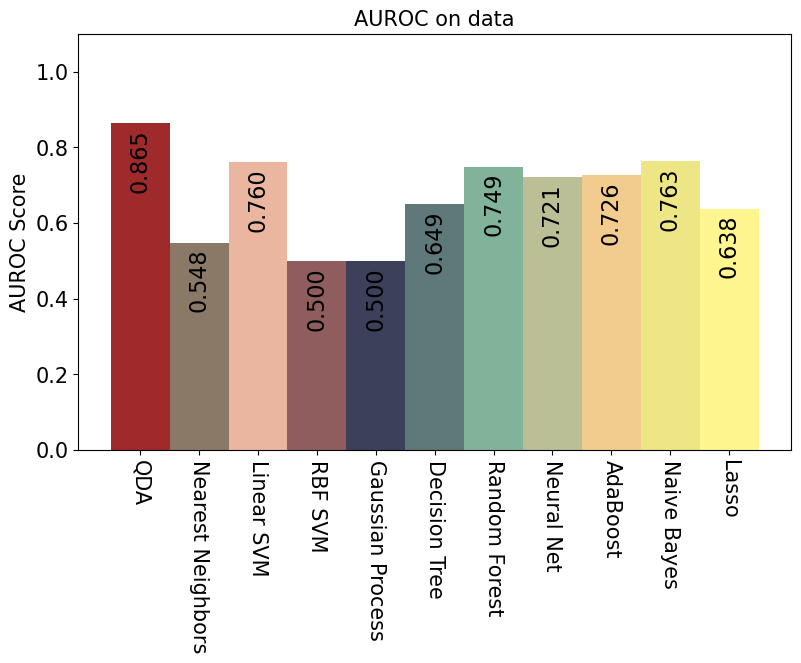

In [25]:
roc2 = results
drawML1(roc2)

In [130]:
#绘制多重auroc的曲线
def drawAUROC(roc3):
    model_names = roc3['classifier'].unique().tolist()

    model_aucs = []
    for model in model_names:
        model_aucs.append(roc3[roc3['classifier']==model]['AUC'].tolist()) #读取results的auc的值

    num_models = len(model_names)

    fig, ax = plt.subplots(figsize=(10,8))#画布大小

    model_axs = []
    #设置颜色
    colors = ['#9e2a2b','#897966', '#EAB69F',  '#8F5D5D','#3D405B', '#5F797B', '#81B29A', '#BABF95', '#F2CC8F','#EEE685','#FFF68F']

    for i, name_, clf_ in zip(range(num_models), model_names, classifiers):
        clf_.fit(x1_7, y1)
        if name_ == "RBF SVM":
            y_pred = clf_.predict(x0_7)
            y_prob = y_pred
        if name_ == "Lasso":
            y_prob = clf_.predict(x0_7)
            y_pred = np.around(y_prob,0).astype(int)
        else:
            y_pred = clf_.predict(x0_7)
            y_prob = clf_.predict_proba(x0_7)[:,1] 
        fpr, tpr, threshod = metrics.roc_curve(y0,y_prob) #计算fpr，tpr，auc值并绘图
        roc_auc = auc(fpr,tpr)
        model_axs.append(ax.plot(fpr, tpr, linewidth=2, label='%s (AUROC = %0.3f)' % (name_, roc_auc), color = colors[i]))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.plot([0,1],[0,1],linewidth=2,color='navy',linestyle="--") #斜线
    ax.set_ylabel('True Positive Rate',size=20)
    ax.set_xlabel('False Positive Rate',size=20)
    ax.set_title('AUROC',size=20)
    ax.set_ylim(ymin=0,ymax=1.05)
    ax.set_xlim(xmin=0,xmax=1.05)
    ax.tick_params(labelsize=15)
    ax.legend()
    
    plt.legend(loc='lower right',prop={'size':16})#设置画布外图例的大小和格式
    fig.tight_layout()
    plt.savefig("E:/算法和数据结构/python/shap output/PVT-816/auc_curve_7features_.png",dpi=300)
    plt.show()    

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please chang

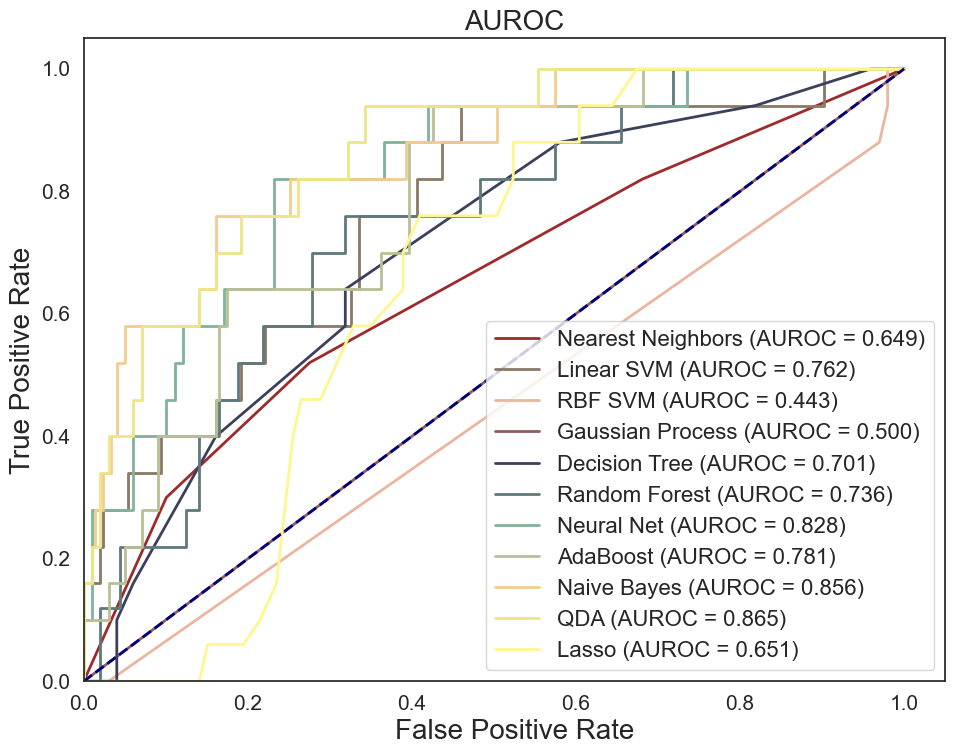

In [131]:
roc3 = results
drawAUROC(roc3)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


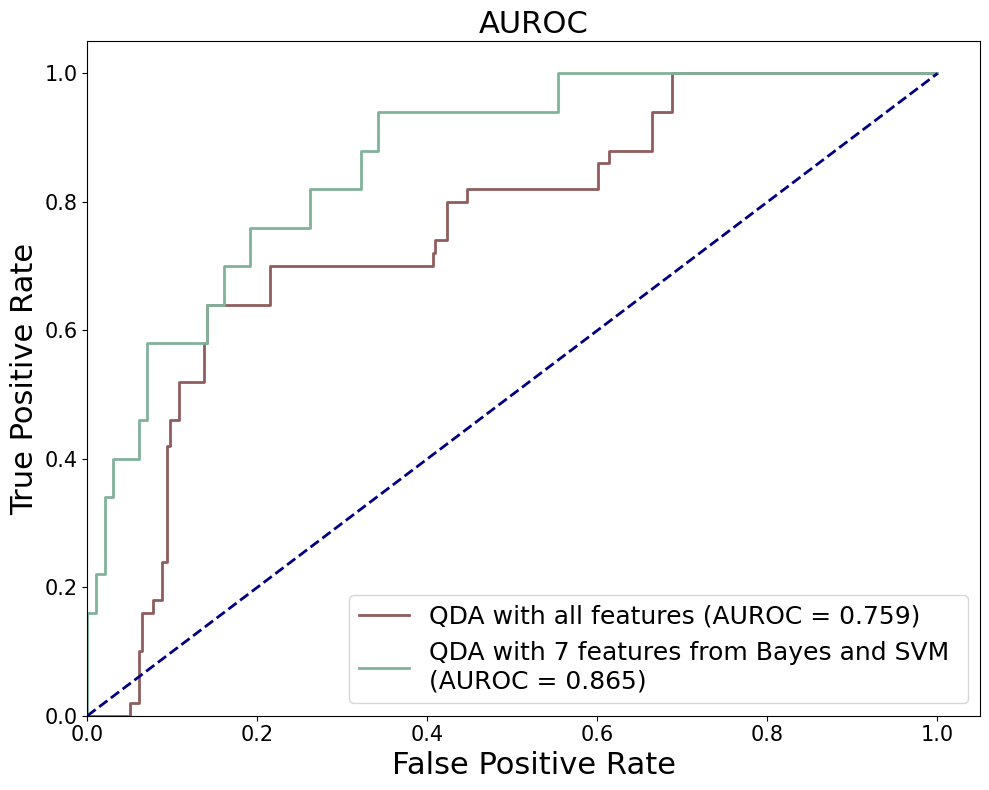

In [19]:
#QDA auroc 对比 在测试集上/在训练集上
QDA_7 = QuadraticDiscriminantAnalysis() #QDA with 7 features
QDA_14 = QuadraticDiscriminantAnalysis() # QDA with 14 features

QDA_14.fit(x1,y1)
y_prob = QDA_14.predict_proba(x0)[:,1]
fpr1, tpr1, threshod1 = metrics.roc_curve(y0,y_prob)
roc_auc1 = auc(fpr1,tpr1) #计算QDAwith14features的auc值

QDA_7.fit(x1_7,y1)
y_prob_7 = QDA_7.predict_proba(x0_7)[:,1]
fpr2, tpr2, threshod2 = metrics.roc_curve(y0,y_prob_7)
roc_auc2 = auc(fpr2,tpr2)#计算QDAwith7features的auc值

#绘制图像
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr1, tpr1, linewidth=2, label='QDA with all features (AUROC = %0.3f)' %  roc_auc1, color = '#8F5D5D')
ax.plot(fpr2, tpr2, linewidth=2, label='QDA with 7 features from Bayes and SVM \n(AUROC = %0.3f)' %  roc_auc2, color =  '#81B29A')
ax.plot([0,1],[0,1],linewidth=2,color='navy',linestyle="--")
ax.set_ylabel('True Positive Rate',size=22)
ax.set_xlabel('False Positive Rate',size=22)
ax.set_title('AUROC',size=22)
ax.set_ylim(ymin=0,ymax=1.05)
ax.set_xlim(xmin=0,xmax=1.05)
ax.legend()

plt.legend(loc ='lower right',prop={'size':18})#设置图例大小和格式
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()
plt.savefig("E:/算法和数据结构/python/shap output/PVT-816/QDA_compareincenter0.png",dpi=300)
plt.show()   

# 统计分类结果和精确率、召回率；绘制分类器roc曲线

In [102]:
#计算QDA在all 14 features/7 features各方面的指标
clf2 = QuadraticDiscriminantAnalysis()
clf2.fit(x1_7, y1)
y_pred = clf2.predict(x0_7)
y_prob = clf2.predict_proba(x0_7)[:,1] 
score = metrics.accuracy_score(y0, y_pred)
fpr, tpr, threshod = metrics.roc_curve(y0,y_prob)
roc_auc = auc(fpr,tpr)
precision = precisionCalc(y0,y_pred)
recall = recallCalc(y0,y_pred)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


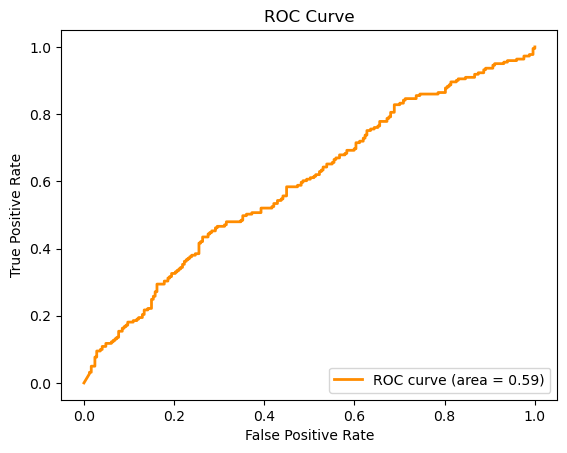

In [32]:
#绘制某分类器的roc曲线图
lw = 2
plt.subplot(1,1,1)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  # 假正率为横坐标，真正率为纵坐标做曲线
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 绘制center0中各指标的箱线图

In [102]:
#计算QDA的获得当前分类预测结果的概率，计算各项指标
clf = QuadraticDiscriminantAnalysis()
clf.fit(x1_7, y1)
y_pred = clf.predict(x0_7)
y_prob = clf.predict_proba(x0_7)[:,1] 
score = metrics.accuracy_score(y0, y_pred)
fpr, tpr, threshod = metrics.roc_curve(y0,y_prob)
roc_auc = auc(fpr,tpr)
precision = precisionCalc(y0,y_pred)
recall = recallCalc(y0,y_pred)

#计算QDA分类器分类的不同类的个数，同时统计y_prob_QDA以绘制箱线图
count = sum(1 for x,y in zip(y_pred,y0) if x==0 and x==y)
count2 = sum(1 for i in y_pred if i == 1)
print(count,count2)
print(precision, recall,score)
print(len(y_pred))
y_prob
y_prob_QDA = pd.DataFrame(y_prob)
y_prob_QDA

214 125
0.82 0.328 0.7327586206896551
348


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


,0
0,0.629984
1,0.054563
2,0.056824
3,0.002654
4,0.112980
...,...
343,0.950801
344,0.106140
345,0.818470
346,0.010266


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Non-PVT vs. PVT: p=7.08e-02


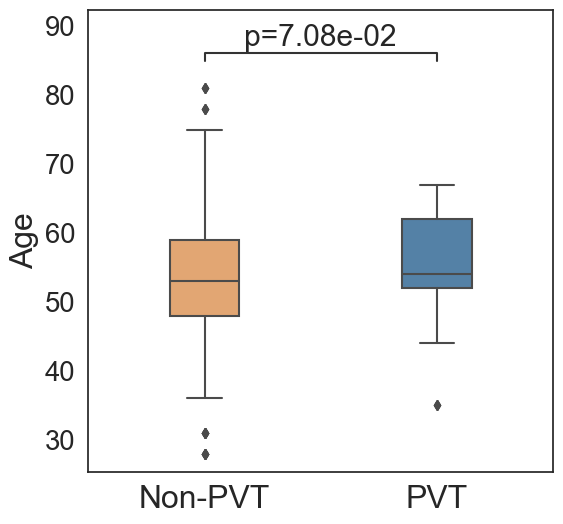

In [119]:
#PV', 'PT', 'PTA', 'cps','PVD', 'APTT','Age','QDA_probe'绘制这八个指标的箱线图
pdt = x_center0['Age']
#pdt = y_prob_QDA.loc[:,0]

pdt_df = pd.DataFrame( {'special feature':pdt,'label':y0.ravel()}, columns = ['special feature','label'])
pdt_df.replace(to_replace={'label':1}, value='PVT', inplace=True) #将数据中1，0的分类转换为‘PVT’‘Non-PVT’
pdt_df.replace(to_replace={'label':0}, value='Non-PVT', inplace=True)

sns.set(context='notebook',style='white',font_scale=1.8, palette='dark')#设置箱线图画布的格式和字体比例
mycolor = {'Non-PVT': 'sandybrown', 'PVT': 'steelblue'}#设置箱线图的颜色
#g = sns.(x='label', y='special feature', kind='box',order=['Non-PVT','PVT'],
                #data=pdt_df, width=0.3, aspect=1.0,palette=mycolor)
plt.figure(figsize=(6,6))

x='label'
y='special feature'
order=['Non-PVT','PVT']
g = sns.boxplot(x=x, y=y,order=order,
                data=pdt_df, width=0.3,palette=mycolor)#boxplot绘制箱线图，设定大小，颜色，数据
g.set(xlabel=None,ylabel="Age")

PVTs = pdt_df.loc[(pdt_df.label=="PVT")].loc[:,"special feature"].values #获取pdt_df内PVTs和Non-PVT的数据
Non_PVTs = pdt_df.loc[(pdt_df.label=="Non-PVT")].loc[:,"special feature"].values

pairs=[('Non-PVT','PVT')]
pvalues = [scipy.stats.mannwhitneyu(PVTs, Non_PVTs, alternative="two-sided").pvalue]#计算显著性特征 p value
formatted_pvalues = [f"p={p:.2e}" for p in pvalues]
annotator = Annotator(g, pairs, data=pdt_df, x=x, y=y, order=order) #引入annotator模块绘制p value
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()

g.yaxis.label.set_size(23)
plt.xticks(fontsize=23)
plt.savefig('E:/算法和数据结构/python/shap output/PVT-816/Age.png',dpi=100,bbox_inches='tight')

# 分类器交叉验证和网格搜索，绘制调参曲线

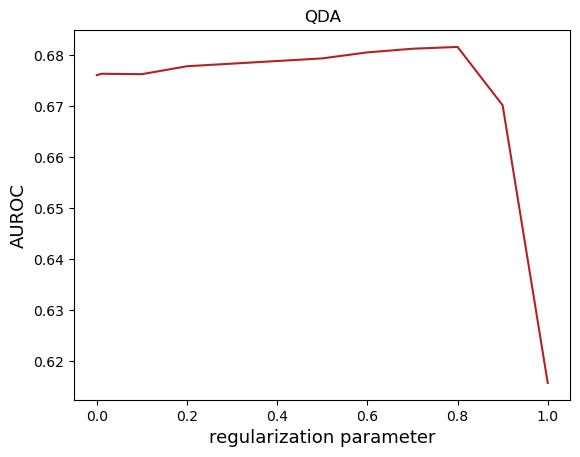

In [24]:
#QDA
scorel = []
for reg_param_ in [0.0,0.01,0.1,0.2,0.5,0.6,0.7,0.8,0.9,1]: #设置可调参数reg_param的值
    QDA = QuadraticDiscriminantAnalysis(reg_param=reg_param_)
    scores = cross_val_score(QDA,x1_7,y1,cv=5,scoring ="roc_auc",n_jobs=-1) #5折交叉验证
    score = scores.mean() #取平均数
    scorel.append(score)
plt.plot([0.0,0.01,0.1,0.2,0.5,0.6,0.7,0.8,0.9,1], scorel, color='firebrick')
plt.title("QDA")
plt.xlabel("regularization parameter",fontsize=13)
plt.ylabel("AUROC",fontsize=13)
plt.show()

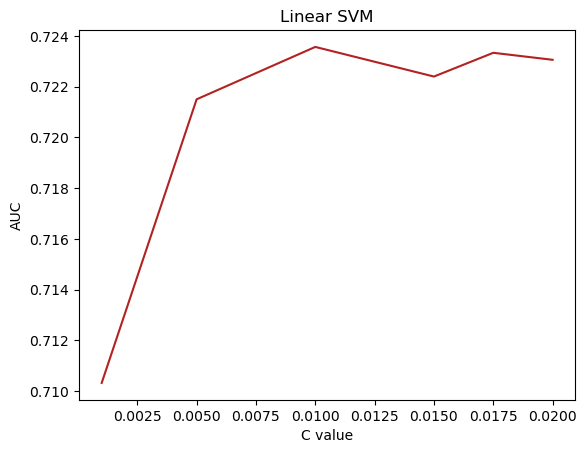

In [15]:
#Linear SVM
scorel = []
for C in [0.001, 0.005, 0.01, 0.015, 0.0175, 0.02]:#设置可调参数c value的值
    svm = SVC(kernel="linear", C=C)
    scores = cross_val_score(svm,x1,y1,cv=5,scoring ="roc_auc",n_jobs=-1) #5折交叉验证
    score = scores.mean() #取平均数
    scorel.append(score)
plt.plot([0.001, 0.005, 0.01, 0.015, 0.0175, 0.02], scorel, color='firebrick')
plt.title("Linear SVM")
plt.xlabel("C value")
plt.ylabel("AUC")
plt.show()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

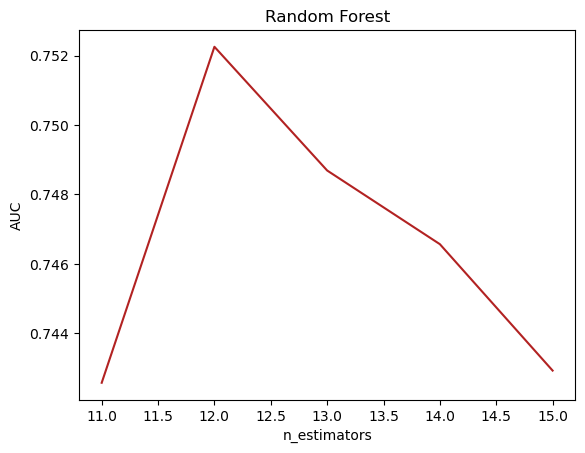

In [55]:
#Random Forests
scorel = []
for i in range(10,15): #设置可调参数n_estimators的值
    rfc = RandomForestClassifier(max_depth=5, n_estimators=i+1, max_features=1,random_state=311)
    scores = cross_val_score(rfc,x1,y1,cv=5,scoring ="roc_auc")#5折交叉验证
    score = scores.mean() #取平均数
    scorel.append(score)
plt.plot(range(11,16), scorel, color='firebrick')
plt.title("Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("AUC")
plt.show()

In [55]:
#center1上训练，迭代各分类器进行cross validation
results = pd.DataFrame(columns = ['classifier','AUC','ACC'])
for name, clf in zip(names, classifiers):
    clf.fit(x1, y1)
    scores_val_auc = cross_val_score(clf,x1,y1,cv=5,scoring ="roc_auc",n_jobs=-1) #5折交叉验证
    scores_val_acc = cross_val_score(clf,x1,y1,cv=5,n_jobs=-1)#n_jobs=-1调用所有可用的核心工作
    score_val_auc = scores_val_auc.mean() #取平均数
    score_val_acc = scores_val_acc.mean()
    results = results.append({'classifier':name,'AUC':score_val_auc,'ACC':score_val_acc},ignore_index=True)
results

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

,classifier,AUC,ACC
0,Nearest Neighbors,0.664394,0.626104
1,Linear SVM,0.704792,0.636834
2,RBF SVM,0.518885,0.527774
3,Gaussian Process,0.607754,0.656005
4,Decision Tree,0.616619,0.581171
5,Random Forest,0.684317,0.636742
6,Neural Net,0.708968,0.643171
7,AdaBoost,0.627133,0.576870
8,Naive Bayes,0.693348,0.628346
9,QDA,0.678099,0.619675


In [56]:
results.to_csv('C:/Users/qjc/Documents/WeChat Files/wxid_1795xchr20ad21/FileStorage/File/2023-08/Data/Results_7features_cross_val.csv',sep=',')